In [9]:
import numpy as np
import pandas as pd

# Tampilkan semua kolom
pd.set_option('display.max_columns', None)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
base_dir = "C:\Purwadhika\Dataset\\"
path = base_dir + "Airbnb_Bangkok_cleaned.csv"
df = pd.read_csv(path)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Bintang\AppData\Local\Temp\ipykernel_7372\3771522824.py:1: SyntaxWarning: invalid escape sequence '\P'
  base_dir = "C:\Purwadhika\Dataset\\"


,id,name,host_id,host_name,district,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,is_price_outlier
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,False
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,private room,1316,1,0,NaN,0.00,2,358,0,False
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,private room,800,60,0,NaN,0.00,1,365,0,False
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,private room,1286,7,2,2022-04-01,0.03,1,323,1,False
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,private room,1905,1,0,NaN,0.00,3,365,0,False


C:\Users\Bintang\AppData\Local\Temp\ipykernel_7372\2631371128.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_district_reviews.index, x=top_district_reviews.values, palette="magma")


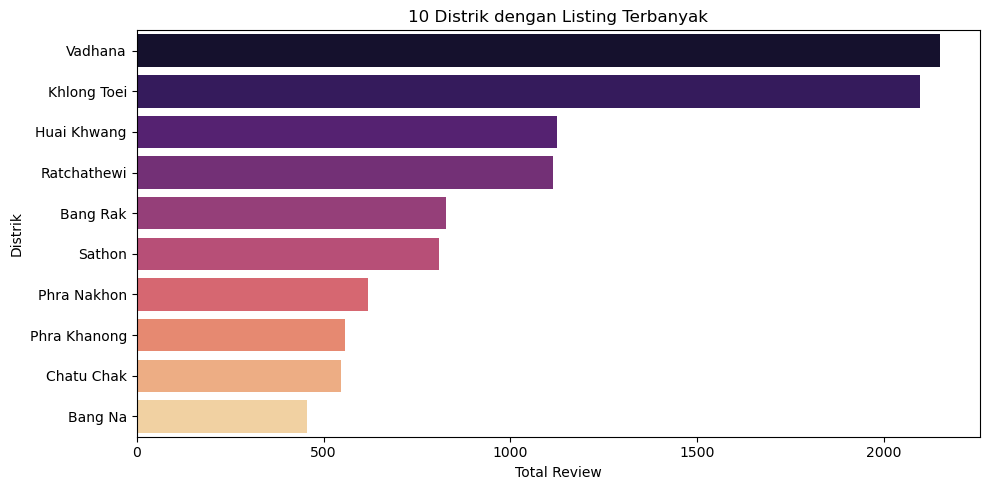

In [11]:
# Distrik dengan jumlah listing terbanyak
top_district_reviews = df.groupby('district')['id'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_district_reviews.index, x=top_district_reviews.values, palette="magma")
plt.title("10 Distrik dengan Listing Terbanyak")
plt.xlabel("Total Review")
plt.ylabel("Distrik")
plt.tight_layout()
plt.show()

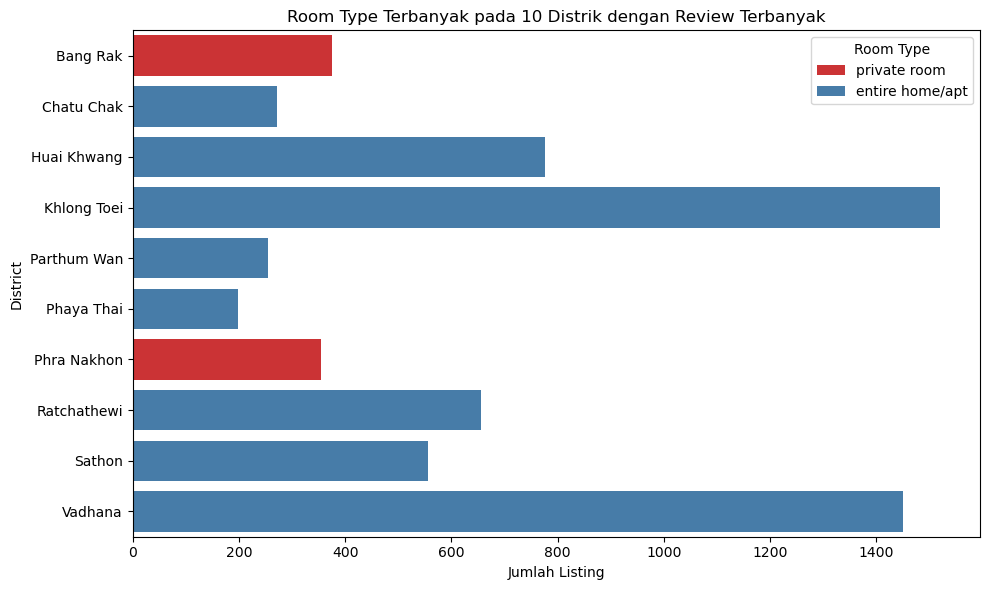

In [7]:
# Ambil room_type paling banyak pada top_district_reviews
top_district_room_type = (
    df[df['district'].isin(top_district_reviews.index)]
    .groupby(['district', 'room_type'])['name']
    .count()
    .reset_index()
)

# Pilih room_type terbanyak per district
top_room_type_per_district = top_district_room_type.loc[
    top_district_room_type.groupby('district')['name'].idxmax()
]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_room_type_per_district,
    y='district',
    x='name',
    hue='room_type',
    palette='Set1'
)
plt.title("Room Type Terbanyak pada 10 Distrik dengan Review Terbanyak")
plt.xlabel("Jumlah Listing")
plt.ylabel("District")
plt.legend(title="Room Type")
plt.tight_layout()
plt.show()

Pastikan file 'Airbnb_Bangkok_cleaned.csv' berada di direktori yang sama.


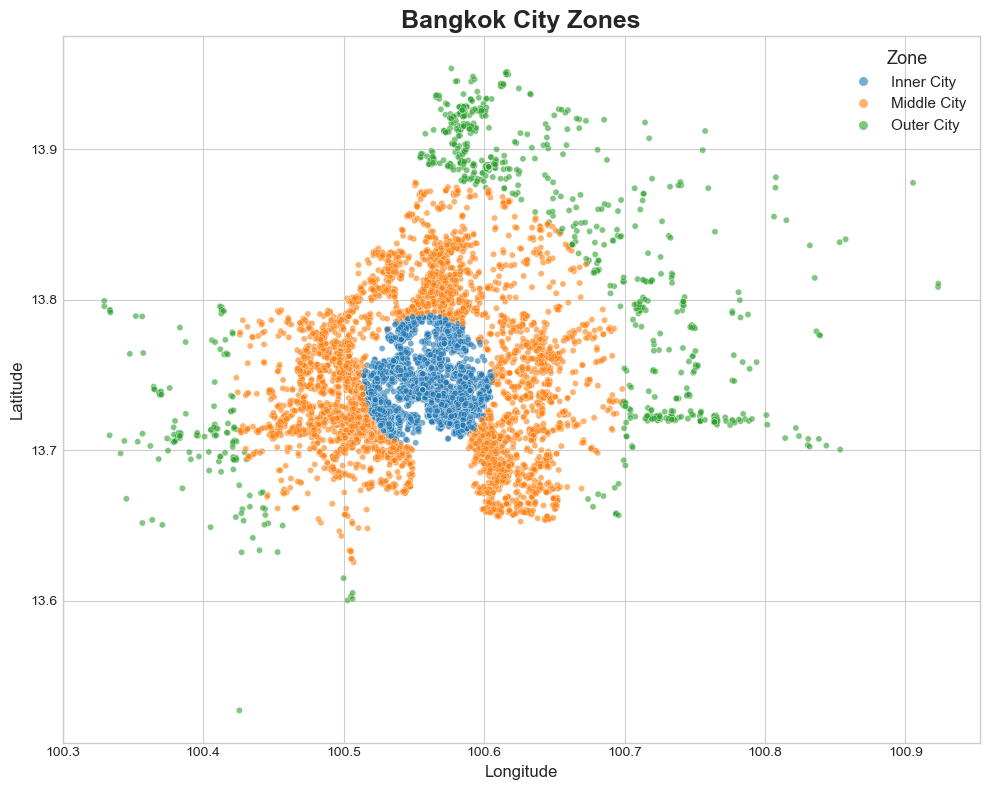

: 

In [ ]:
# Fungsi untuk menghitung jarak Haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam km
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Muat dataset
try:
    df = pd.read_csv('Airbnb_Bangkok_cleaned.csv')
except FileNotFoundError:
    print("Pastikan file 'Airbnb_Bangkok_cleaned.csv' berada di direktori yang sama.")
    exit()

# Tentukan pusat kota
center_lat, center_lon = df['latitude'].mean(), df['longitude'].mean()

# Hitung jarak dari pusat
df['distance_from_center'] = df.apply(
    lambda row: haversine_distance(center_lat, center_lon, row['latitude'], row['longitude']),
    axis=1
)

# Definisikan fungsi untuk assign zona
def assign_zone(distance):
    if distance <= 5:
        return 'Inner City'
    elif 5 < distance <= 15:
        return 'Middle City'
    else:
        return 'Outer City'

# Buat kolom 'zone'
df['zone'] = df['distance_from_center'].apply(assign_zone)


# --- Bagian 2: Konversi ke GeoDataFrame dan Visualisasi dengan Basemap ---

# 1. Konversi pandas DataFrame menjadi GeoPandas GeoDataFrame
# GeoDataFrame memerlukan kolom 'geometry' yang berisi informasi spasial.
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # CRS awal untuk koordinat lat/lon (WGS84)
)

# 2. Ubah Coordinate Reference System (CRS) ke Web Mercator (EPSG:3857)
# Contextily memerlukan CRS ini untuk menarik tile peta dengan benar.
gdf = gdf.to_crs(epsg=3857)

# 3. Buat plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Tentukan warna untuk setiap zona
zone_colors = {
    'Inner City': '#1f77b4',
    'Middle City': '#ff7f0e',
    'Outer City': '#2ca02c'
}
zone_order = ['Inner City', 'Middle City', 'Outer City']

# 4. Plot setiap zona secara terpisah untuk mengontrol legenda
for zone in zone_order:
    gdf[gdf['zone'] == zone].plot(
        ax=ax, 
        color=zone_colors[zone], 
        label=zone,
        markersize=25,
        alpha=0.7,
        edgecolor='k', # Tambahkan outline hitam tipis pada titik
        linewidth=0.5
    )

# 5. Tambahkan basemap dari OpenStreetMap menggunakan Contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 6. Kustomisasi tampilan plot
ax.set_title('Bangkok City Zones with OpenStreetMap Background', fontsize=18, fontweight='bold')
ax.set_axis_off() # Matikan sumbu x dan y karena sudah ada peta
ax.legend(title='Zone', title_fontsize='13', fontsize='11', markerscale=2)

plt.tight_layout()
plt.show()


In [10]:
import folium

C:\Users\Bintang\AppData\Local\Temp\ipykernel_18932\3205659862.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_room.index, y=avg_price_by_room.values, palette='pastel')


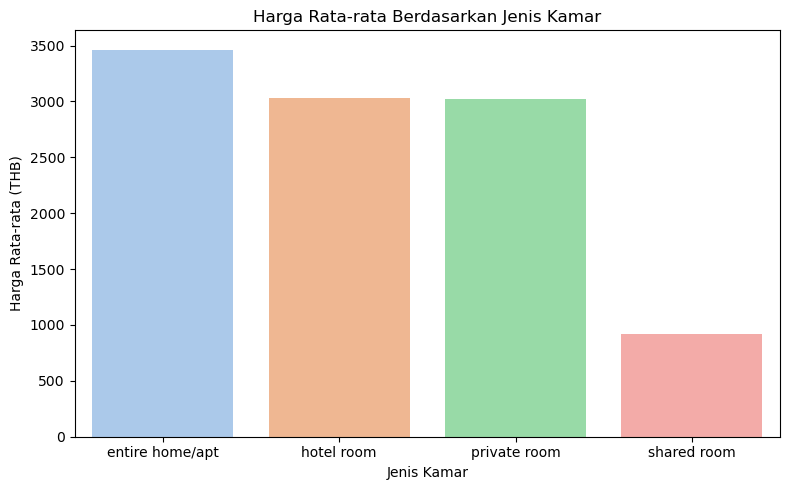

In [11]:
plt.figure(figsize=(8, 5))
avg_price_by_room = df.groupby('room_type')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_room.index, y=avg_price_by_room.values, palette='pastel')
plt.title("Harga Rata-rata Berdasarkan Jenis Kamar")
plt.xlabel("Jenis Kamar")
plt.ylabel("Harga Rata-rata (THB)")
plt.tight_layout()
plt.show()

In [17]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Opsional: Hapus baris yang tanggalnya tidak valid (jika ada)
df.dropna(subset=['last_review'], inplace=True)

# Langkah 2: Lanjutkan kode Anda yang sudah benar secara logika
recent_date = df['last_review'].max()
three_months_ago = recent_date - pd.DateOffset(months=3)
recent_reviews = df[df['last_review'] >= three_months_ago]

# Sekarang, 'recent_reviews' akan berisi data yang benar
print(recent_reviews)

                       id                                               name  \
11                1765918                     2BR apt in a cozy neighborhood   
19                1793000                   The Duplex - Asoke- Luxury 92sqm   
28                 145343                Boutique Rooms Near Bangkok Airport   
30                 156583  Studio near Chula University/Silom walk to MRT...   
32                 159854    Deluxe one Bedroom Condo w.Pool-GYM & Sauna 8-7   
...                   ...                                                ...   
15696  785741287659406453                        ใจกลางเมืองติดห้างไอคอนสยาม   
15712  785976692600131294      1br/Free pool&gym/WIFI-Asok/SukhumvitBTS! 2PP   
15727  786248090308669514                 Vibrant Luxe 2 Bedroom | Thong Lor   
15728  786318268883527580                 Vibrant Luxe 2 Bedroom | Thong Lor   
15780  788841933134248110  Stunning river view in the heart of BKK 5min/t...   

         host_id host_name     district

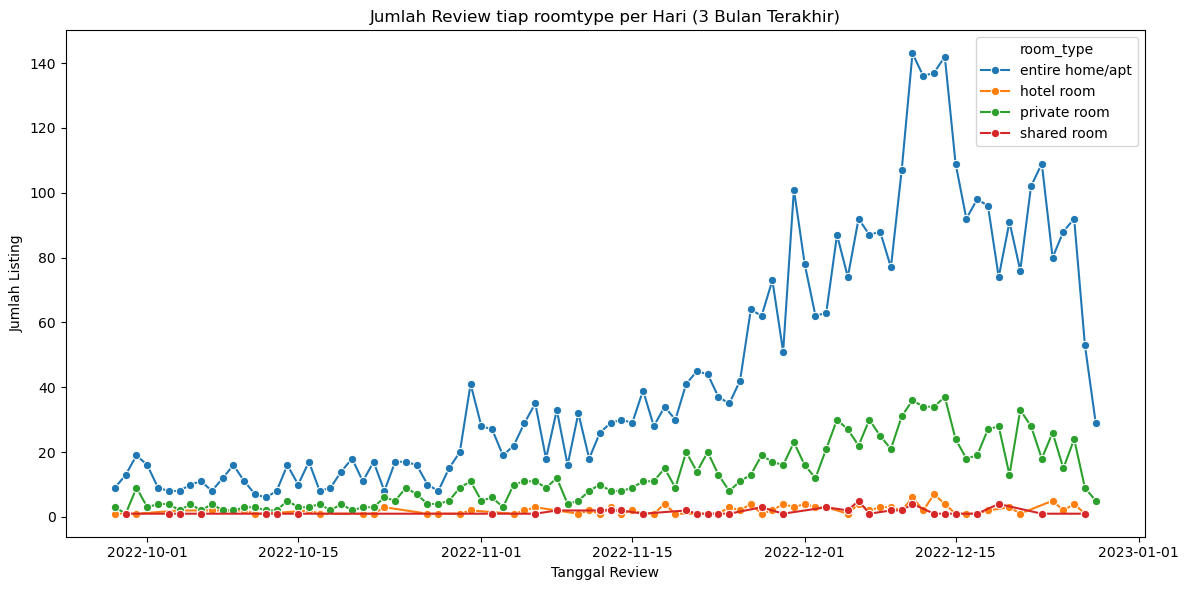

In [18]:
# Filter 3 bulan terakhir
recent_date = df['last_review'].max()
three_months_ago = recent_date - pd.DateOffset(months=3)
recent_reviews = df[df['last_review'] >= three_months_ago]

# Hitung jumlah listing per room_type per tanggal review
room_type_daily = (
    recent_reviews.groupby(['last_review', 'room_type'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=room_type_daily,
    x='last_review',
    y='count',
    hue='room_type',
    marker='o'
)
plt.title('Jumlah Review tiap roomtype per Hari (3 Bulan Terakhir)')
plt.xlabel('Tanggal Review')
plt.ylabel('Jumlah Listing')
plt.tight_layout()
plt.show()


In [19]:
# Tandai jumlah listing per host
df['host_type'] = df['calculated_host_listings_count'].apply(lambda x: 'Individual' if x == 1 else 'Professional')


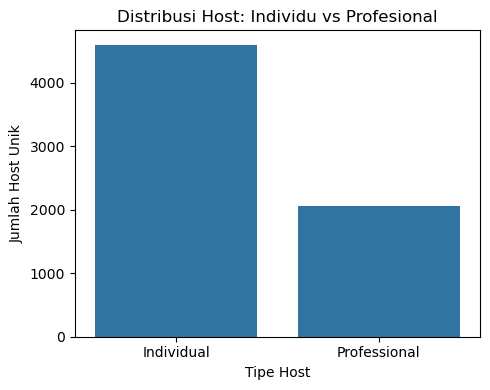

In [ ]:
host_counts = df[['host_id', 'host_type']].drop_duplicates()['host_type'].value_counts()

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.barplot(x=host_counts.index, y=host_counts.values)
plt.title('Distribusi Host: Individu vs Profesional')
plt.ylabel('Jumlah Host Unik')
plt.xlabel('Tipe Host')
plt.tight_layout()
plt.show()


In [ ]:
host_summary = df.groupby('host_type').agg({
    'id': 'count',  # jumlah listing
    'price': 'mean',
    'number_of_reviews': 'mean',
    'reviews_per_month': 'mean'
}).rename(columns={'id': 'total_listings'}).reset_index()

host_summary


,host_type,total_listings,price,number_of_reviews,reviews_per_month
0,Individual,4599,3136.585562,10.241574,0.264775
1,Professional,11239,3229.113355,19.265771,0.619435


C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\1620778254.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=host_summary, x='host_type', y='price', palette='Set3')


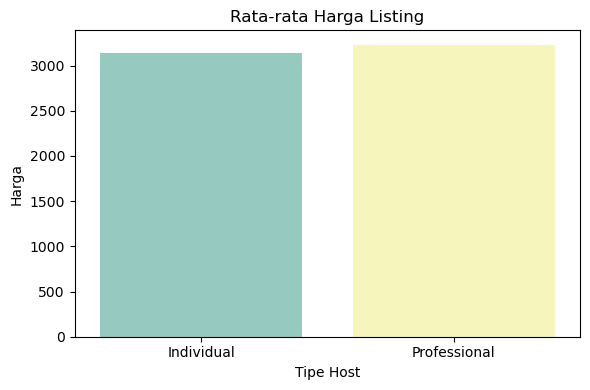

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\1620778254.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=host_summary, x='host_type', y='number_of_reviews', palette='Set2')


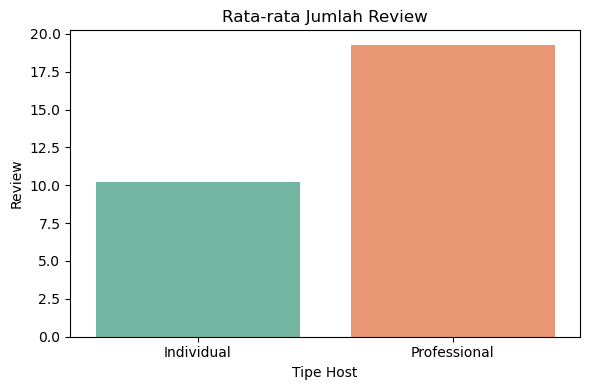

In [ ]:
# Harga rata-rata
plt.figure(figsize=(6, 4))
sns.barplot(data=host_summary, x='host_type', y='price', palette='Set3')
plt.title('Rata-rata Harga Listing')
plt.ylabel('Harga')
plt.xlabel('Tipe Host')
plt.tight_layout()
plt.show()

# Rata-rata review
plt.figure(figsize=(6, 4))
sns.barplot(data=host_summary, x='host_type', y='number_of_reviews', palette='Set2')
plt.title('Rata-rata Jumlah Review')
plt.ylabel('Review')
plt.xlabel('Tipe Host')
plt.tight_layout()
plt.show()


C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\3659794647.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


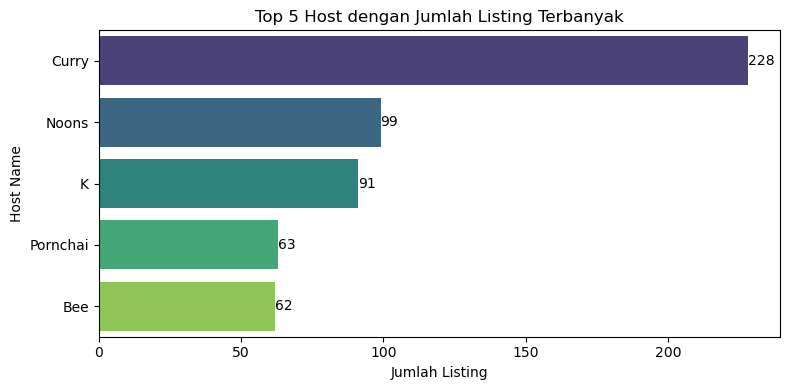

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(
    y=top5_hosts_multiple.index,
    x=top5_hosts_multiple.values,
    palette="viridis"
)
plt.title("Top 5 Host dengan Jumlah Listing Terbanyak")
plt.xlabel("Jumlah Listing")
plt.ylabel("Host Name")

for i, value in enumerate(top5_hosts):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\3550804552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


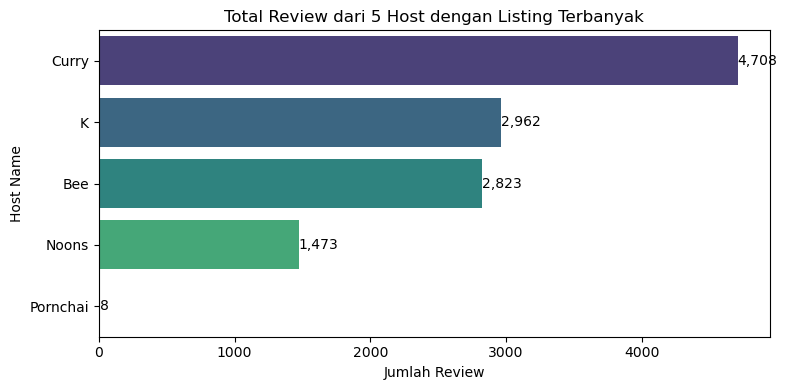

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(
    y=top5_hosts_reviews.index,
    x=top5_hosts_reviews.values,
    palette="viridis"
)
plt.title("Total Review dari 5 Host dengan Listing Terbanyak")
plt.xlabel("Jumlah Review")
plt.ylabel("Host Name")

for i, value in enumerate(top5_hosts_reviews):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\4123332417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


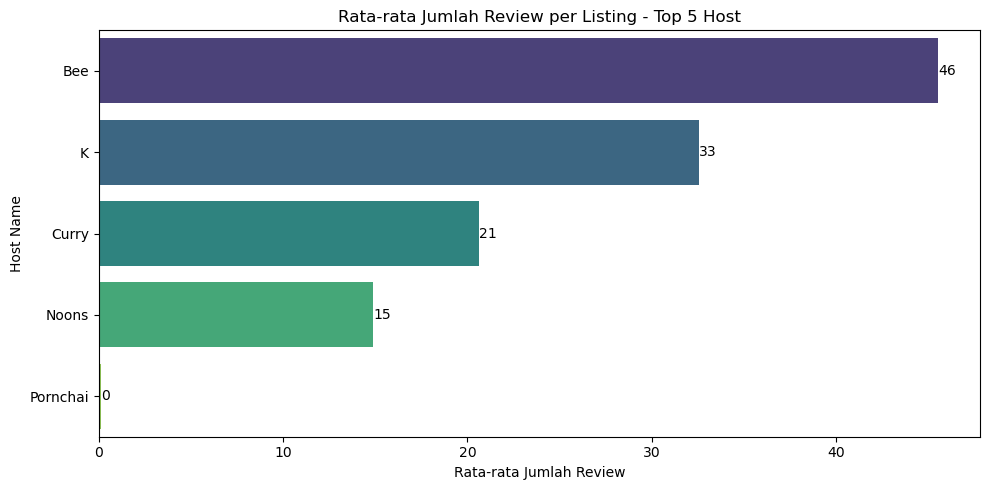

In [ ]:
# Plot barplot horizontal
plt.figure(figsize=(10, 5))
sns.barplot(
    x=avg_review_per_listing_top5_hosts.values,
    y=avg_review_per_listing_top5_hosts.index,
    palette='viridis'  # kamu bisa ganti palette sesuai preferensi
)

plt.title("Rata-rata Jumlah Review per Listing - Top 5 Host")
plt.xlabel("Rata-rata Jumlah Review")
plt.ylabel("Host Name")

for i, value in enumerate(avg_review_per_listing_top5_hosts):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\3550804552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


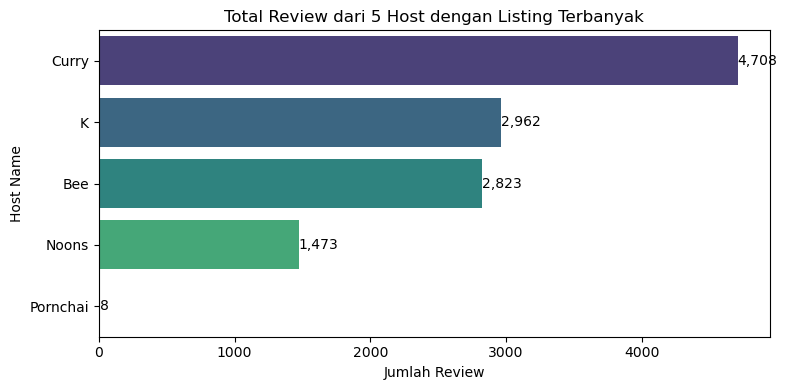

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(
    y=top5_hosts_reviews.index,
    x=top5_hosts_reviews.values,
    palette="viridis"
)
plt.title("Total Review dari 5 Host dengan Listing Terbanyak")
plt.xlabel("Jumlah Review")
plt.ylabel("Host Name")

for i, value in enumerate(top5_hosts_reviews):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\2875687916.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


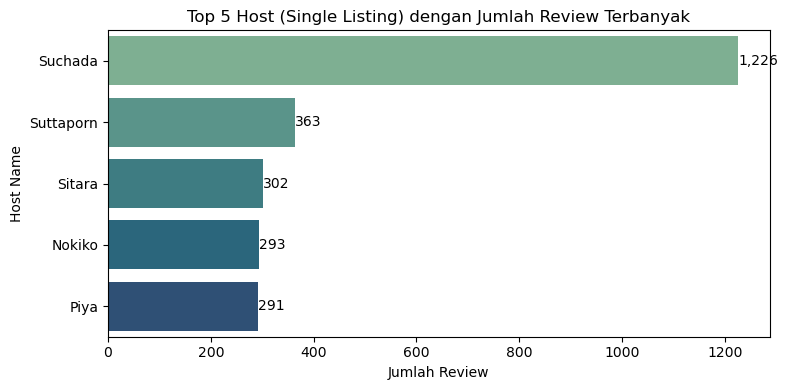

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(
    y=top5_single_listing_hosts.index,
    x=top5_single_listing_hosts.values,
    palette="crest"
)
plt.title("Top 5 Host (Single Listing) dengan Jumlah Review Terbanyak")
plt.xlabel("Jumlah Review")
plt.ylabel("Host Name")

for i, value in enumerate(top5_single_listing_hosts):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Bintang\AppData\Local\Temp\ipykernel_16984\401472888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


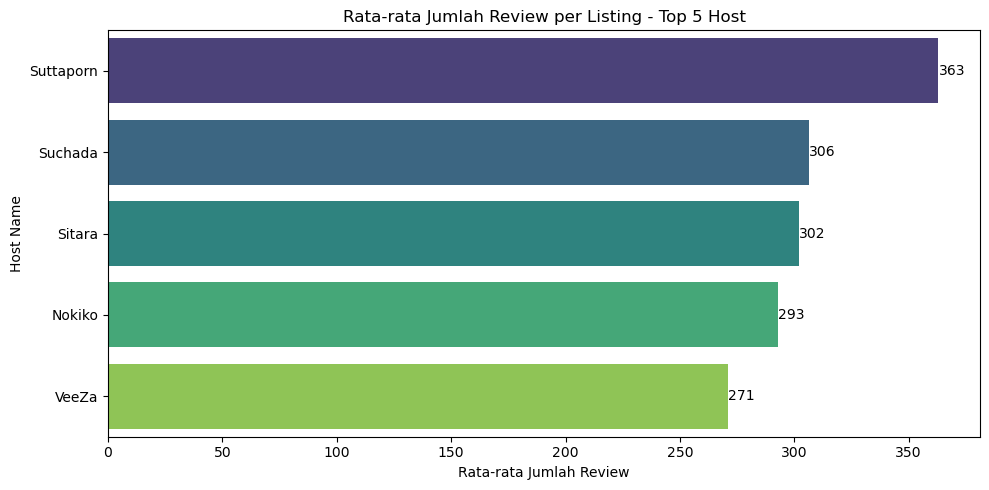

In [ ]:
# Plot barplot horizontal
plt.figure(figsize=(10, 5))
sns.barplot(
    x=avg_review_top5_single_listing_hosts.values,
    y=avg_review_top5_single_listing_hosts.index,
    palette='viridis'  # kamu bisa ganti palette sesuai preferensi
)

plt.title("Rata-rata Jumlah Review per Listing - Top 5 Host")
plt.xlabel("Rata-rata Jumlah Review")
plt.ylabel("Host Name")

for i, value in enumerate(avg_review_top5_single_listing_hosts):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
top5_hosts_individual = (
    df['host_name']
    .value_counts()
    .head(5)
)
print(top5_hosts_individual)